In [291]:
import os
import sys
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import scipy.stats as stats

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler

In [292]:
RANDOM_STATE = 42

### Key Features

- **Order_ID**: Unique identifier for each order.
- **Distance_km**: The delivery distance in kilometers.
- **Weather**: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.
- **Traffic_Level**: Traffic conditions categorized as Low, Medium, or High.
- **Time_of_Day**: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.
- **Vehicle_Type**: Type of vehicle used for delivery, including Bike, Scooter, and Car.
- **Preparation_Time_min**: The time required to prepare the order, measured in minutes.
- **Courier_Experience_yrs**: Experience of the courier in years.
- **Delivery_Time_min**: The total delivery time in minutes (target variable).

In [293]:
df = pd.read_csv('Food_Delivery_Times.csv')

In [294]:
df.sample(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
757,820,7.04,Clear,Low,Afternoon,Bike,11,8.0,38
348,91,2.83,Windy,Medium,Afternoon,Scooter,14,6.0,28
226,545,12.55,Windy,Low,Evening,Bike,13,8.0,51
596,288,11.08,Clear,Low,Evening,Scooter,28,2.0,58
747,753,12.74,Clear,Low,Afternoon,Scooter,12,0.0,63


In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [296]:
df.nunique()

Order_ID                  1000
Distance_km                785
Weather                      5
Traffic_Level                3
Time_of_Day                  4
Vehicle_Type                 3
Preparation_Time_min        25
Courier_Experience_yrs      10
Delivery_Time_min          108
dtype: int64

In [297]:
# Drop 'Order_ID' as it's a unique identifier and not useful for modeling
df.drop('Order_ID', axis=1, inplace=True)

In [298]:
df.isnull().sum()

Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [299]:
df = df.dropna() #we dropped missing values as they constitute small portion of the dataset

I tried filling numerical missing values with the median and categorical missing values with the most frequent ones. However, the metrics did not improve; instead, they worsened. Therefore, I have decided to continue with dropping the rows containing missing values.

In [300]:
df.duplicated().sum()
# no duplicates

0

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             883 non-null    float64
 1   Weather                 883 non-null    object 
 2   Traffic_Level           883 non-null    object 
 3   Time_of_Day             883 non-null    object 
 4   Vehicle_Type            883 non-null    object 
 5   Preparation_Time_min    883 non-null    int64  
 6   Courier_Experience_yrs  883 non-null    float64
 7   Delivery_Time_min       883 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.1+ KB


In [302]:
# Map Traffic_Level (Low-0, Medium-1, High-2)
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Traffic_Level'] = df['Traffic_Level'].map(traffic_map)
# One-hot encode the categorical variables
df = pd.get_dummies(df, columns=['Weather', 'Time_of_Day', 'Vehicle_Type'], drop_first=True)
dummy_columns = df.select_dtypes(include=['bool']).columns
df[dummy_columns] = df[dummy_columns].astype(int)

In [303]:
df.sample(7)

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
177,2.39,1,27,7.0,43,0,1,0,0,1,0,0,0,0
896,3.23,0,25,7.0,42,0,1,0,0,0,1,0,1,0
815,19.94,0,26,6.0,83,0,0,0,0,0,0,0,0,0
36,5.96,1,22,7.0,45,0,0,0,0,0,0,0,0,0
258,17.94,2,22,6.0,85,0,1,0,0,1,0,0,0,1
823,6.81,1,23,2.0,47,0,0,0,0,1,0,0,0,0
290,3.17,1,17,6.0,33,0,0,0,0,1,0,0,0,1


In [304]:
df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,10.051586,0.812005,17.019253,4.639864,56.425821,0.110985,0.212911,0.097395,0.097395,0.304643,0.318233,0.086070,0.194790,0.294451
std,5.688582,0.750505,7.260201,2.922172,21.568482,0.314292,0.409597,0.296663,0.296663,0.460517,0.466055,0.280627,0.396264,0.456054
min,0.590000,0.000000,5.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.748200,0.000000,5.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,1.380000,0.000000,6.000000,0.000000,24.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.130000,0.000000,11.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.280000,1.000000,17.000000,5.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.025000,1.000000,23.000000,7.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
95%,18.988000,2.000000,28.000000,9.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [305]:
df.shape

(883, 14)

### Comment:
- The dataset contains 1,000 records with 9 features, including numerical & categorical values.
- Distance_km: Delivery distances range from 0.59 to 19.99 km, with an average of 10.05 km. Most deliveries fall near the median of 10.28 km.
- Preparation_Time_min: Order preparation times range from 5 to 29 minutes, averaging 17.02 minutes.
- Courier_Experience_yrs: Couriers have up to 9 years of experience, with missing values in 3% of cases. The median experience is 5 years.
- Weather: Includes Clear, Rainy, Snowy, Foggy, and Windy, with some missing values.
- Traffic_Level: Categorized as Low, Medium, or High, with missing values.
- Time_of_Day: Divided into Morning, Afternoon, Evening, and Night, with missing values.
- Vehicle_Type: Includes Bike, Scooter, and Car.
- High variability in Delivery_Time_min suggests the presence of outliers or varying delivery conditions, warranting further investigation. Additionally, the significant difference between the 99th percentile and the maximum value may indicate the presence of outliers.
- Distribution in categorical features should be analyzed further to ensure model reliability.

**Delivery_Time_min** is our target variabe to predict.

- Shortest deliveries (~0.59 km - 1 km). Example: Nazarbayev University → Mega Silk Way
- Longest deliveries (~19.99 km). Example: Astana Airport → Nurly Zhol Railway Station
- Comparable Route (~10.06 km): Nazarbayev University → Astana Airport

#### Simple Logic Before Analysis:
- Delivery_Time & Distance_km Dependence: A longer distance generally leads to a longer delivery time.
- Delivery_Time & Preparation_Time_min Dependence: If delivery time includes preparation time, they may have a high correlation. However, there can be cases where preparation time is long, but the distance is short, and traffic levels are low, resulting in a shorter overall delivery time. Conversely, short preparation time with high distance and traffic can still lead to longer delivery times. Therefore, all relevant features should be considered.
- Delivery_Time & Courier_Experience_yrs Dependence: Courier experience might have some correlation with delivery time, but it is likely weak. Inexperience could cause delays in ideal conditions, but overall, it may have minimal impact.
- Delivery_Time & Weather Dependence: Rain, snow, and strong winds can significantly increase delivery time.
- Delivery_Time & Traffic_Level Dependence: Traffic levels may be influenced by bad weather or the time of day. A multicollinearity test should be conducted before building the model to check for dependencies between these variables.
- Delivery_Time & Time_of_Day Dependence: Morning and evening hours may lead to higher traffic levels, which can increase delivery time. However, bicycles might be less affected by traffic, as they can take alternative routes.
- Delivery_Time & Vehicle_Type Dependence: Bicycles can be quicker than cars in high-traffic conditions, but in other cases, they tend to be slower. Cars and scooters may be faster when traffic is low.

## EDA

In [306]:
df.columns

Index(['Distance_km', 'Traffic_Level', 'Preparation_Time_min',
       'Courier_Experience_yrs', 'Delivery_Time_min', 'Weather_Foggy',
       'Weather_Rainy', 'Weather_Snowy', 'Weather_Windy',
       'Time_of_Day_Evening', 'Time_of_Day_Morning', 'Time_of_Day_Night',
       'Vehicle_Type_Car', 'Vehicle_Type_Scooter'],
      dtype='object')

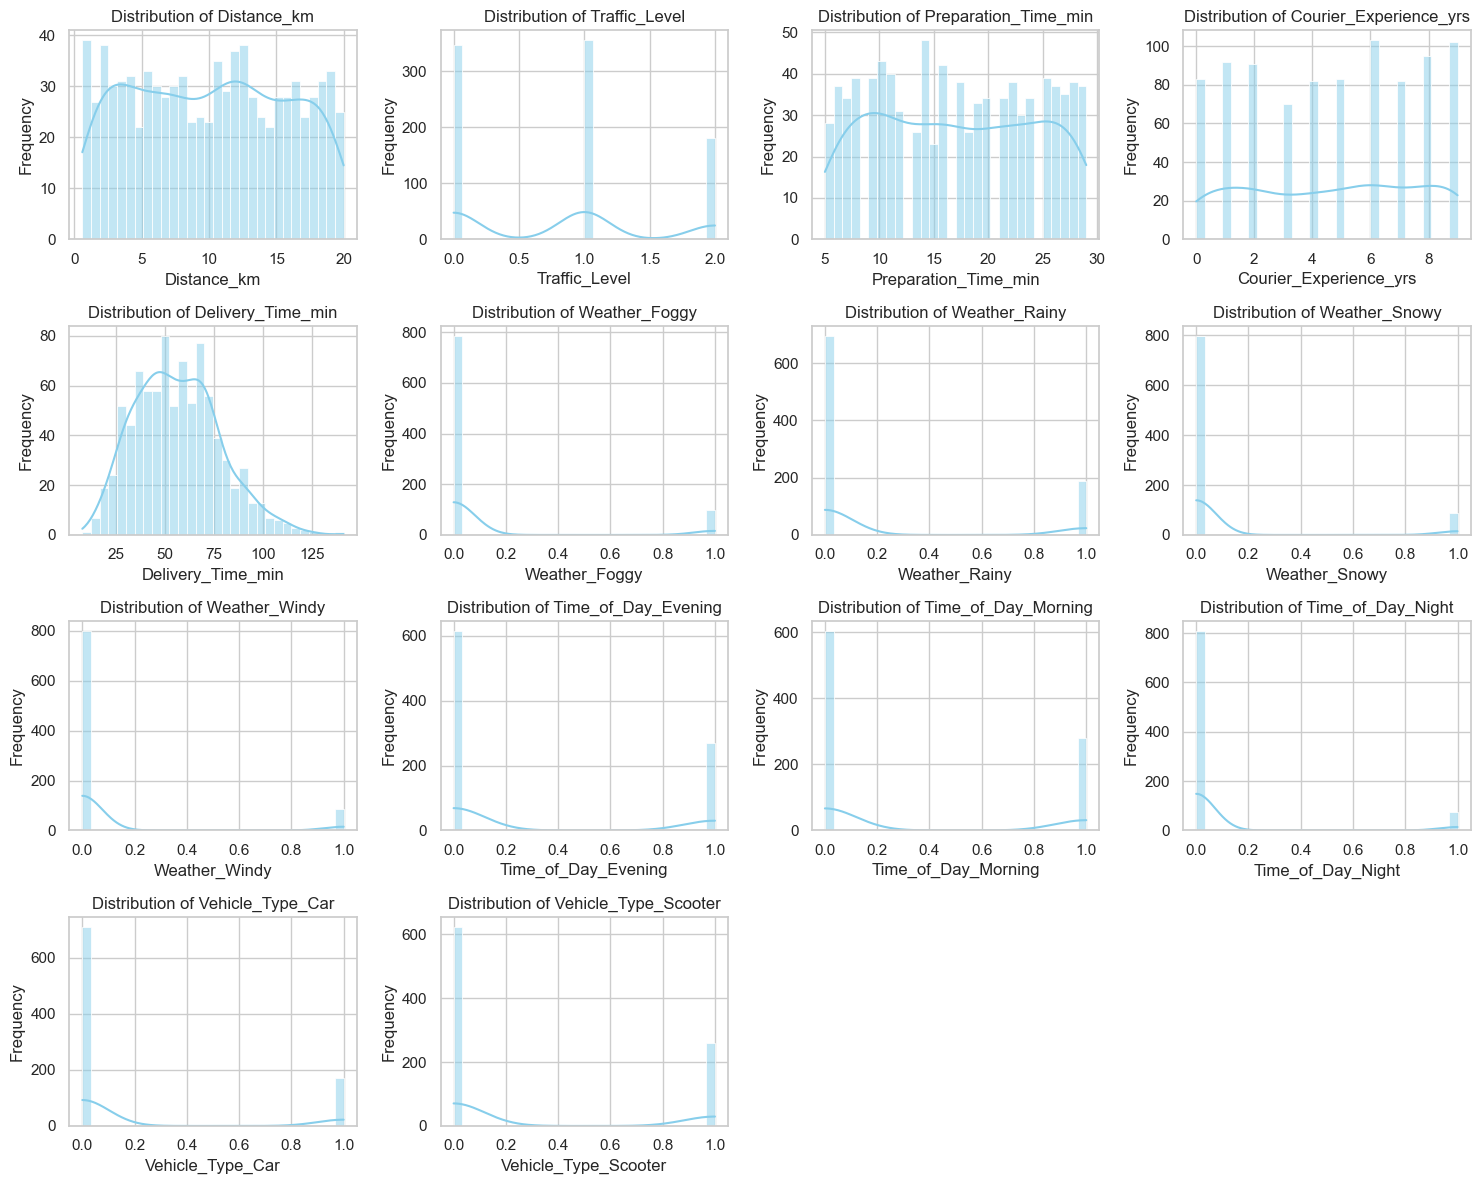

In [307]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color="skyblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any extra subplots
for j in range(len(df.columns), len(axes)):
    fig.delaxes(axes[j])
fig.savefig("distribution_plots.png", format="png")
plt.tight_layout()
plt.show()

In [308]:
df['Courier_Experience_yrs'].unique()

array([1., 2., 5., 9., 6., 4., 7., 3., 8., 0.])

- The distribution of distance is relatively uniform across 0-20 km, with slightly higher frequencies around 0-2.5 km and 12.5-15 km, indicating no significant clustering for very short or long distances.
- Traffic levels are mostly low or medium (0 and 1), with significantly fewer occurrences of high traffic (2).
- Preparation time is evenly spread across 5-30 minutes, with noticeable peaks at 10 and 15 minutes, suggesting common preparation durations.
- Courier experience is well-distributed, with slight peaks at 6 and 9 years, showing a mix of new and experienced couriers.
- Delivery time follows a right-skewed distribution, with most deliveries taking 40-80 minutes and fewer taking over 100 minutes, likely due to long distances or traffic. 
- Weather conditions like fog, rain, snow, and wind are rare, as most deliveries occur under normal conditions.
- Deliveries are more frequent during mornings and evenings, aligning with peak order times, while night deliveries are less common.
- Vehicle types are dominated by cars and scooters, with slightly more deliveries using cars, though their performance may vary with traffic and distance.

Distance_km


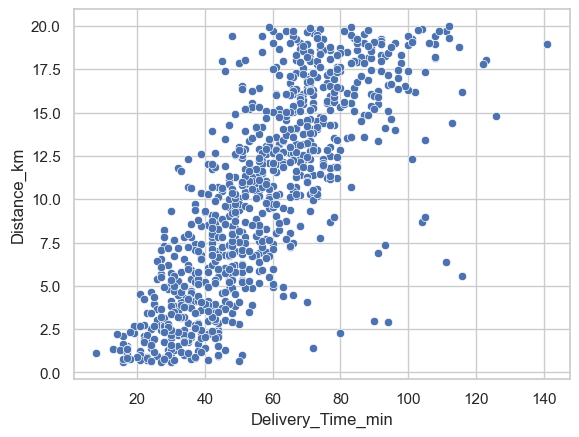

Traffic_Level


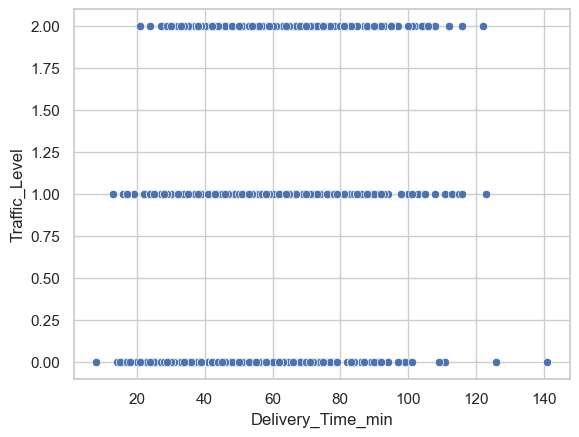

Preparation_Time_min


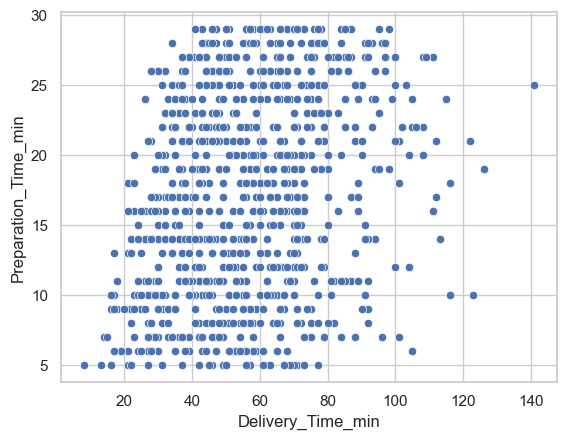

Courier_Experience_yrs


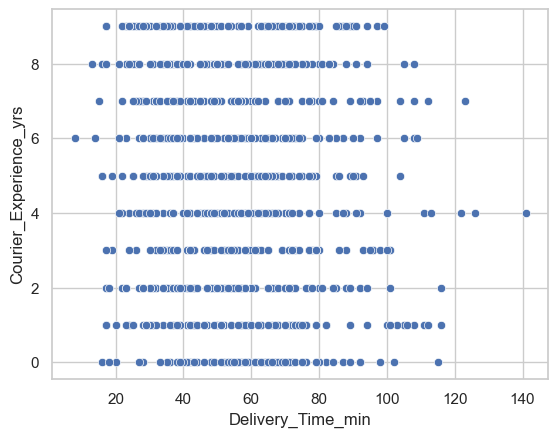

Delivery_Time_min


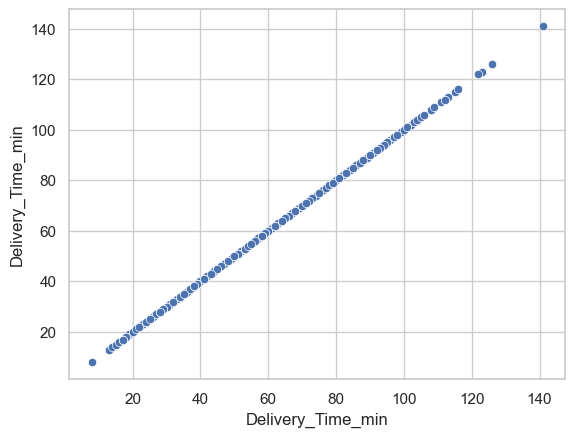

Weather_Foggy


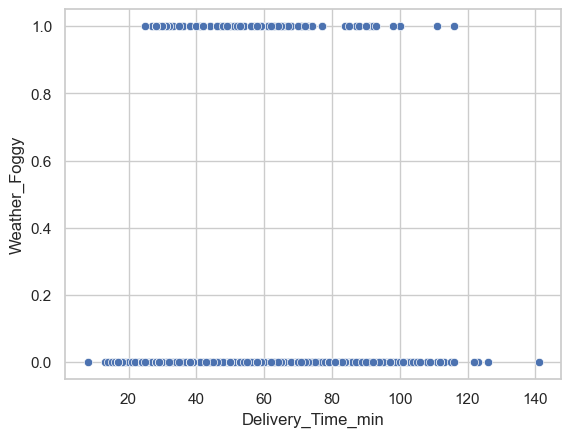

Weather_Rainy


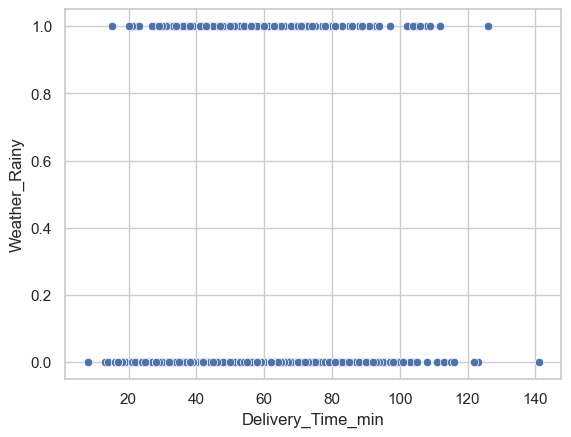

Weather_Snowy


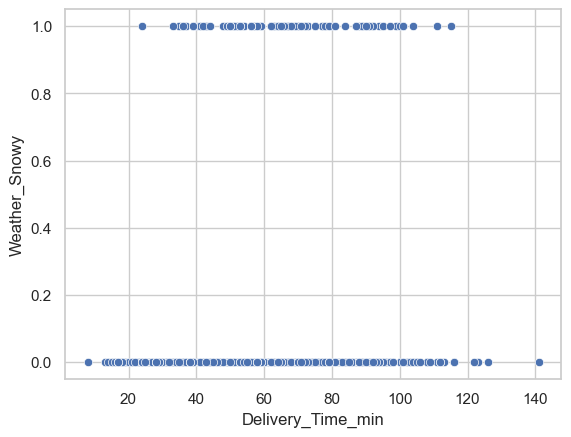

Weather_Windy


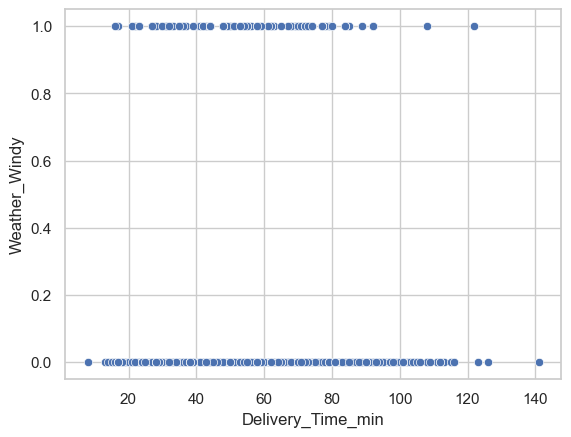

Time_of_Day_Evening


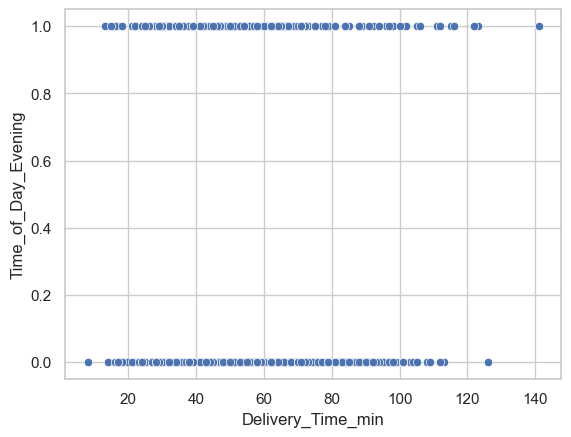

Time_of_Day_Morning


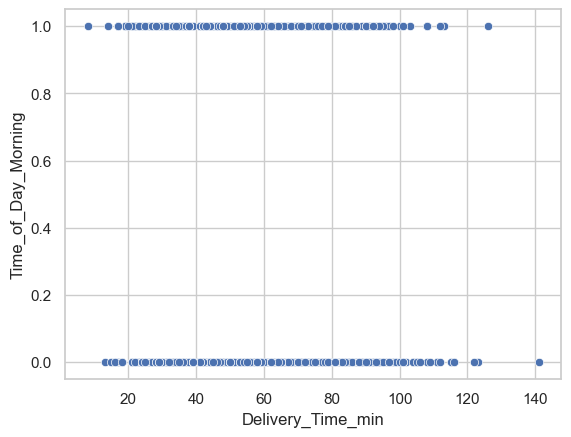

Time_of_Day_Night


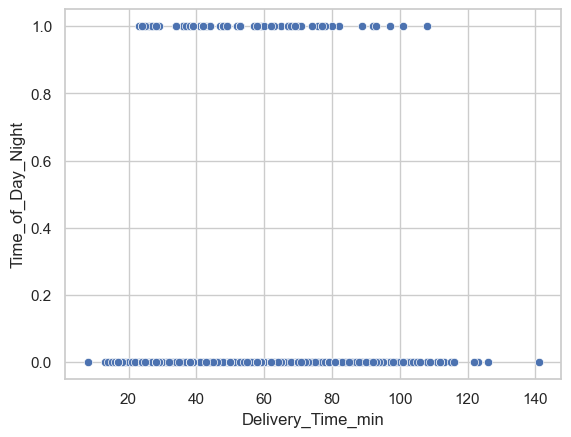

Vehicle_Type_Car


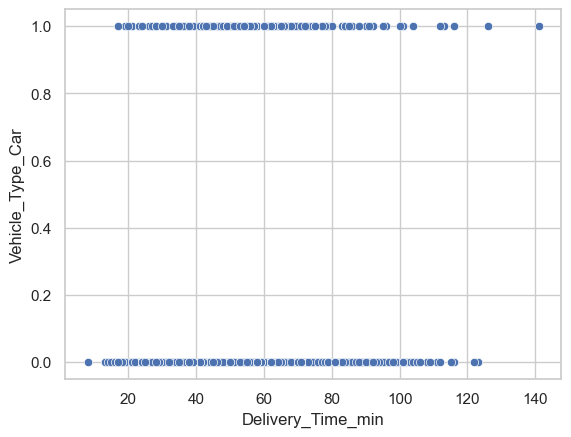

Vehicle_Type_Scooter


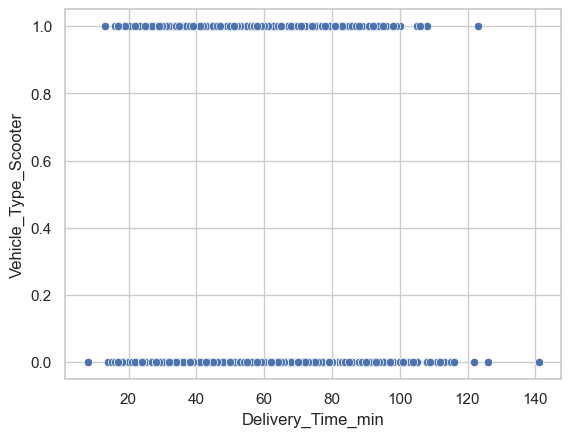

In [309]:
for col in df.columns:
    print(f"{col}")
    sns.scatterplot(data=df, x='Delivery_Time_min', y=col)
    plt.show()

#### Comment:
The analysis of delivery time relationships reveals several insights. Delivery time has a clear positive correlation with distance, confirming that longer distances typically result in longer delivery times. Traffic level, while not linearly correlated, shows a wider range of delivery times under higher traffic conditions, suggesting it indirectly affects delays when combined with other factors like vehicle type or weather. Preparation time appears to have minimal direct impact on delivery time but might contribute to overall delays when paired with other variables. Courier experience shows little to no effect on delivery time, indicating it’s likely a secondary factor. Weather conditions, such as rain, snow, or wind, do not show strong direct trends but could influence delays through their impact on traffic or vehicle efficiency. Time of day (morning, evening, or night) also does not show clear trends but likely contributes indirectly by affecting traffic levels. Vehicle type plays a conditional role: scooters are generally associated with shorter delivery times, while cars handle both short and long deliveries, potentially struggling in high traffic. Night-time deliveries show no distinct patterns and likely depend on factors such as distance or vehicle type. These insights suggest the need to explore interactions between key variables (e.g., traffic level and vehicle type) and include multivariate modeling with features like weather, traffic, and distance to accurately predict delivery times. Statistical tests and feature importance rankings could further validate the impact of these factors and guide model development.

### Correlation Analysis

In [310]:
df.corr()

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
Distance_km,1.000000,0.004186,-0.025518,-0.003372,0.783226,-0.017290,0.031557,0.063908,0.000352,-0.006170,0.032307,-0.043793,0.019192,-0.010131
Traffic_Level,0.004186,1.000000,-0.028466,0.035784,0.195255,-0.026804,-0.002423,-0.029700,0.072146,0.005153,0.005921,0.028465,-0.052095,0.029412
Preparation_Time_min,-0.025518,-0.028466,1.000000,-0.030776,0.296529,-0.027272,-0.000999,0.029660,-0.055618,0.032494,-0.027614,0.013654,0.004606,0.007189
Courier_Experience_yrs,-0.003372,0.035784,-0.030776,1.000000,-0.076787,-0.060129,0.062240,0.013042,0.048354,0.019274,-0.039795,0.004660,-0.013763,0.001391
Delivery_Time_min,0.783226,0.195255,0.296529,-0.076787,1.000000,0.053065,0.064419,0.158301,-0.020487,0.033269,-0.000638,-0.038281,0.029816,-0.035930
Weather_Foggy,-0.017290,-0.026804,-0.027272,-0.060129,0.053065,1.000000,-0.183766,-0.116064,-0.116064,-0.014531,-0.001446,0.032974,-0.000814,0.001138
Weather_Rainy,0.031557,-0.002423,-0.000999,0.062240,0.064419,-0.183766,1.000000,-0.170847,-0.170847,0.022402,-0.022735,-0.031379,0.030592,0.009974
Weather_Snowy,0.063908,-0.029700,0.029660,0.013042,0.158301,-0.116064,-0.170847,1.000000,-0.107905,0.039840,-0.019419,0.008144,0.060260,-0.078126
Weather_Windy,0.000352,0.072146,-0.055618,0.048354,-0.020487,-0.116064,-0.170847,-0.107905,1.000000,-0.051448,0.046184,-0.019094,0.012037,-0.036225
Time_of_Day_Evening,-0.006170,0.005153,0.032494,0.019274,0.033269,-0.014531,0.022402,0.039840,-0.051448,1.000000,-0.452217,-0.203124,-0.033542,0.015077


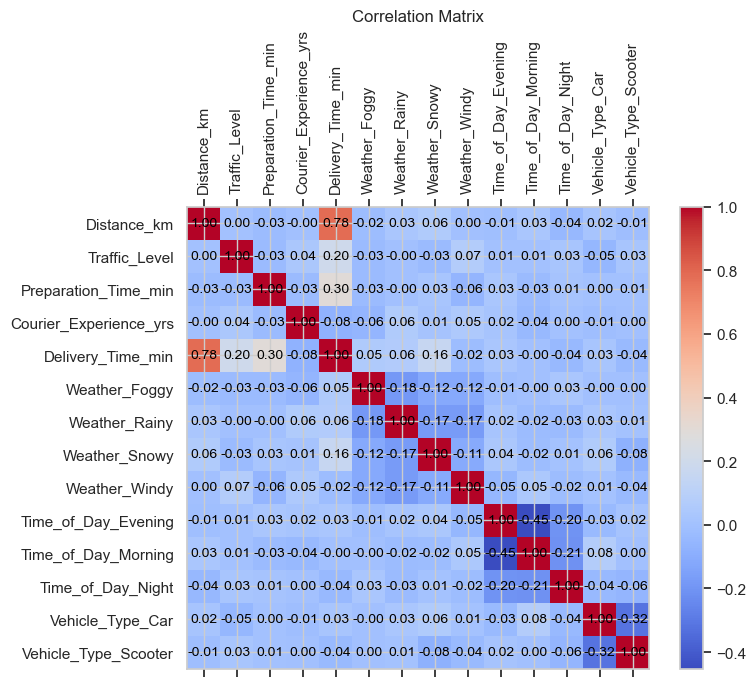

In [311]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

#### Comment:
The correlation matrix shows Distance_km as the strongest predictor of Delivery_Time_min (0.78), with moderate correlations for Preparation_Time_min (0.30), Traffic_Level (0.20). Weather and courier experience have negligible impact. The Time_of_Day variables may have multicollinearity due to one-hot encoding (up to 0.45), so mapping them to ordinal values could be explored to assess metric changes. Key predictors to prioritize are Distance_km, Preparation_Time_min, and Traffic_Level.

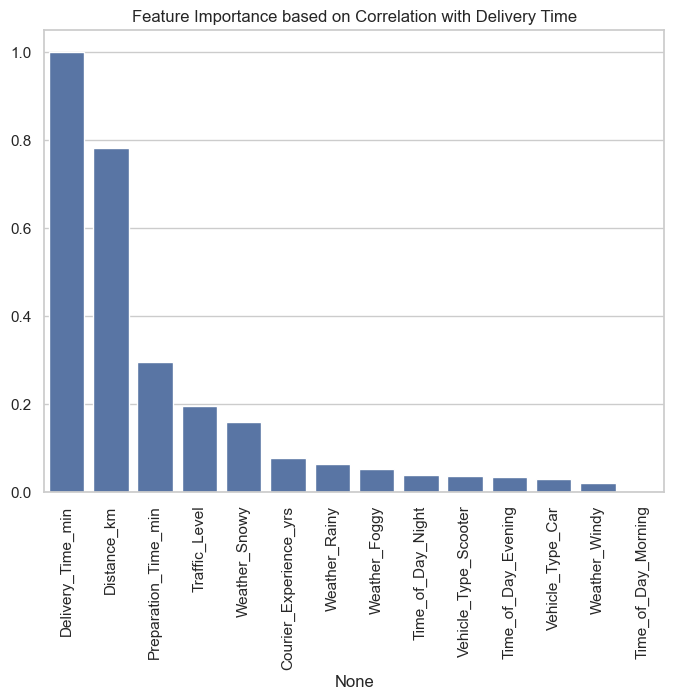

In [312]:
# Feature Importance using Correlation
plt.figure(figsize=(8,6))
sns.barplot(x=corr['Delivery_Time_min'].abs().sort_values(ascending=False).index,
            y=corr['Delivery_Time_min'].abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title('Feature Importance based on Correlation with Delivery Time')
plt.show()

### Outliers

In [313]:
# Example for Delivery Time
Q1 = df['Delivery_Time_min'].quantile(0.25)
Q3 = df['Delivery_Time_min'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Delivery_Time_min'] < lower_bound) | (df['Delivery_Time_min'] > upper_bound)]

In [314]:
outliers

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
29,18.05,1,10,7.0,123,0,0,0,0,1,0,0,0,1
127,18.97,0,25,4.0,141,0,0,0,0,1,0,0,1,0
784,14.83,0,19,4.0,126,0,1,0,0,0,1,0,1,0
924,17.81,2,21,4.0,122,0,0,0,1,1,0,0,0,0


In [315]:
# Example for Delivery Time
Q1 = df['Delivery_Time_min'].quantile(0.25)
Q3 = df['Delivery_Time_min'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Distance_km'] < lower_bound) | (df['Distance_km'] > upper_bound)]
outliers

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter


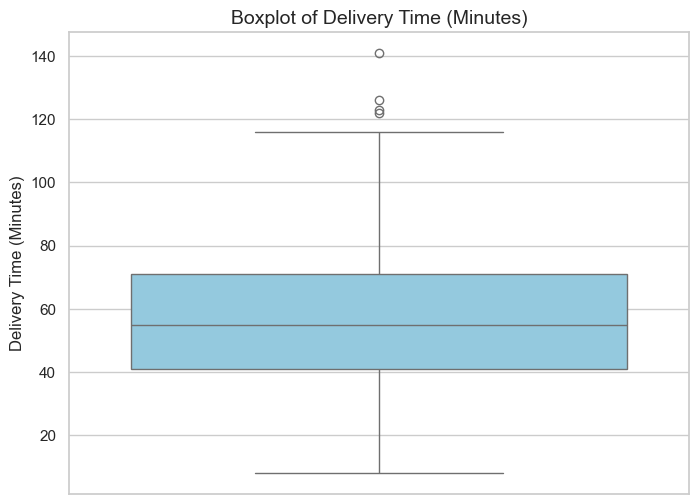

In [316]:
# Set plot size and style
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Create a boxplot for Delivery Time
sns.boxplot(y=df['Delivery_Time_min'], color="skyblue")

# Add plot title and labels
plt.title("Boxplot of Delivery Time (Minutes)", fontsize=14)
plt.ylabel("Delivery Time (Minutes)", fontsize=12)

# Show the plot
plt.show()

#### Comment:
I used capping and flooring outliers with the IQR method because it retains extreme values instead of removing them. This approach ensures that, when similar features are encountered in the test set, they will still indicate that the target value is likely high. Additionally, since we have only 4 outliers, this method is unlikely to distort the dataset significantly.

In [317]:
df['Delivery_Time_min'] = df['Delivery_Time_min'].clip(lower=lower_bound, upper=upper_bound)
print(f"After capping/flooring, Delivery_Time_min range: Min = {df['Delivery_Time_min'].min()}, Max = {df['Delivery_Time_min'].max()}")

After capping/flooring, Delivery_Time_min range: Min = 8, Max = 116


In [318]:
outliers = df[(df['Distance_km'] < lower_bound) | (df['Distance_km'] > upper_bound)]
outliers

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter


#### Comment:
Now we do not have outliers.

### Baseline Model

In [319]:
TARGET = 'Delivery_Time_min'

In [320]:
X = df.drop(TARGET, axis=1)
y = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [321]:
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

Train shape: (706, 13) | Test shape: (177, 13)


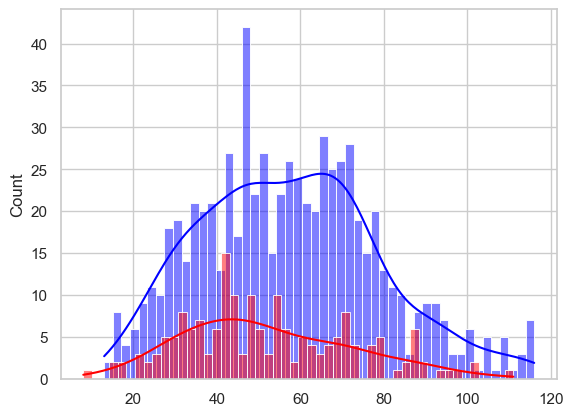

In [322]:
sns.histplot(y_train, kde=True, bins=50, color='blue')
sns.histplot(y_test, kde=True, bins=50, color='red')
plt.show()

In [323]:
X_train.head()

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
685,6.44,0,18,2.0,0,0,0,0,0,0,0,1,0
488,4.14,0,23,2.0,0,1,0,0,0,1,0,0,0
407,9.75,0,22,7.0,0,0,0,0,0,0,0,0,0
402,3.02,1,23,1.0,0,1,0,0,0,1,0,0,0
87,7.30,0,14,7.0,0,0,0,0,0,0,1,0,1


In [324]:
scale_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

# we apply scaling only to selected columns
scaler = StandardScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [325]:
X_train.head()

,Distance_km,Traffic_Level,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Car,Vehicle_Type_Scooter
685,-0.669657,0,0.125871,-0.891439,0,0,0,0,0,0,0,1,0
488,-1.075507,0,0.812618,-0.891439,0,1,0,0,0,1,0,0,0
407,-0.085586,0,0.675269,0.814132,0,0,0,0,0,0,0,0,0
402,-1.273138,1,0.812618,-1.232553,0,1,0,0,0,1,0,0,0
87,-0.517905,0,-0.423526,0.814132,0,0,0,0,0,0,1,0,1


#### Comment:
As seen in the first table, the scales of numerical values differ significantly from the binary features. To address this, we applied a Standard Scaler to the non-binary numerical features (Distance_km, Preparation_Time_min, and Courier_Experience_yrs). This ensures that all features are on a similar scale, allowing them to have a comparable impact on the model.

Training Linear Regression...
Linear Regression - MSE: 67.12, R²: 0.84
Training KNN Regressor...
KNN Regressor - MSE: 96.64, R²: 0.76
Training Decision Tree...
Decision Tree - MSE: 187.63, R²: 0.54
Training Random Forest...
Random Forest - MSE: 96.69, R²: 0.76
Training XGBoost...
XGBoost - MSE: 110.45, R²: 0.73
Training Support Vector Regressor...
Support Vector Regressor - MSE: 95.54, R²: 0.77
Training Gradient Boosting...
Gradient Boosting - MSE: 82.00, R²: 0.80

Model Evaluation Results:
                                 MSE        R²
Linear Regression          67.119239  0.835782
KNN Regressor              96.635028  0.763567
Decision Tree             187.632768  0.540926
Random Forest              96.690974  0.763430
XGBoost                   110.445392  0.729777
Support Vector Regressor   95.535760  0.766256
Gradient Boosting          81.999320  0.799375


C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\3322241796.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R²'], palette="viridis")


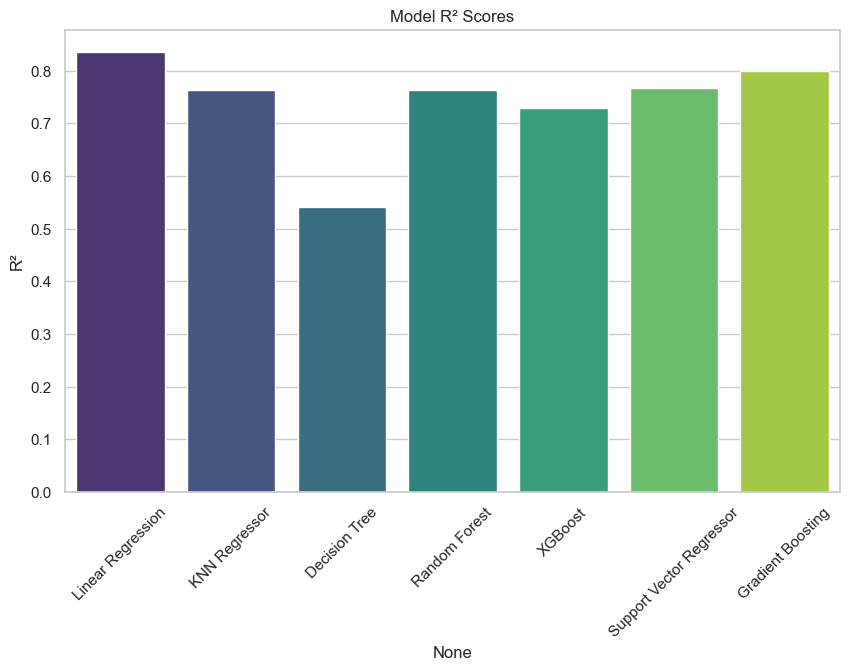

C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\3322241796.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['MSE'], palette="viridis")


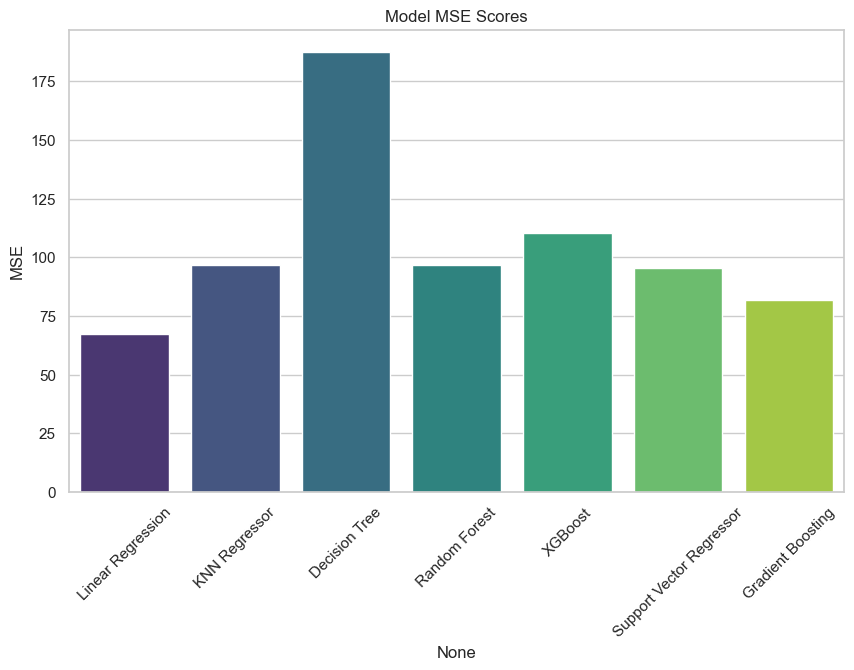

In [327]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# To store results
results = {}

# Iterate through models and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {'MSE': mse, 'R²': r2}

    print(f"{model_name} - MSE: {mse:.2f}, R²: {r2:.2f}")

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R²'], palette="viridis")
plt.title("Model R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['MSE'], palette="viridis")
plt.title("Model MSE Scores")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()


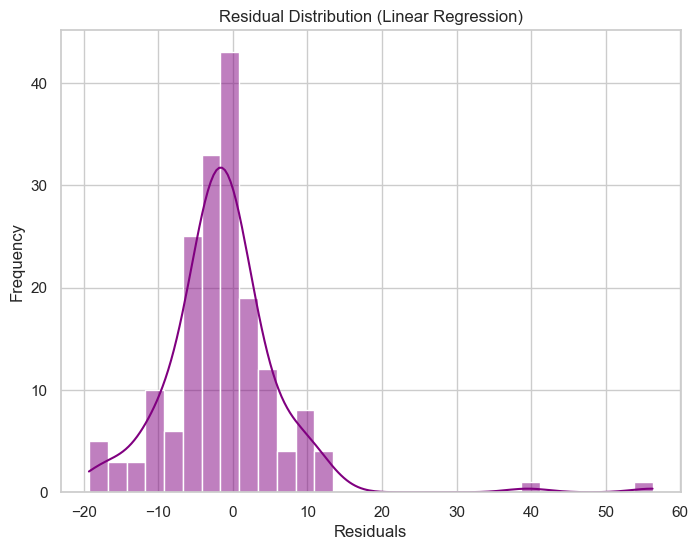

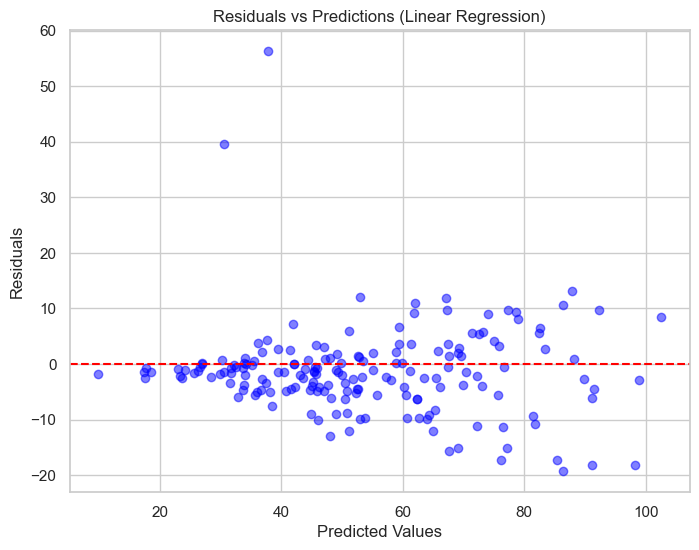

In [328]:
# Residual Analysis for Linear Regression
y_pred_lr = models['Linear Regression'].predict(X_test)
residuals = y_test - y_pred_lr

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residual Distribution (Linear Regression)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (Linear Regression)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


### Experiment with Encoding Time_of_Day

In [329]:
df = pd.read_csv('Food_Delivery_Times.csv')
# Drop 'Order_ID' as it's a unique identifier and not useful for modeling
df.drop('Order_ID', axis=1, inplace=True)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Distance_km             883 non-null    float64
 1   Weather                 883 non-null    object 
 2   Traffic_Level           883 non-null    object 
 3   Time_of_Day             883 non-null    object 
 4   Vehicle_Type            883 non-null    object 
 5   Preparation_Time_min    883 non-null    int64  
 6   Courier_Experience_yrs  883 non-null    float64
 7   Delivery_Time_min       883 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 62.1+ KB


In [330]:
df['Time_of_Day'].unique()

array(['Afternoon', 'Evening', 'Night', 'Morning'], dtype=object)

In [331]:
# Map Traffic_Level (Low-0, Medium-1, High-2), Time_of_Day (Morning-0, Afternoon-1, Evening-2, Night-3)
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Traffic_Level'] = df['Traffic_Level'].map(traffic_map)
time_map = {'Morning':0, 'Afternoon':1, 'Evening':2, 'Night':3}
df['Time_of_Day'] = df['Time_of_Day'].map(time_map)
# One-hot encode the categorical variables
df = pd.get_dummies(df, columns=['Weather', 'Vehicle_Type'], drop_first=True)
dummy_columns = df.select_dtypes(include=['bool']).columns
df[dummy_columns] = df[dummy_columns].astype(int)

In [332]:
df['Time_of_Day'].unique()

array([1, 2, 3, 0], dtype=int64)

In [333]:
df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,Distance_km,Traffic_Level,Time_of_Day,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,10.051586,0.812005,1.158550,17.019253,4.639864,56.425821,0.110985,0.212911,0.097395,0.097395,0.194790,0.294451
std,5.688582,0.750505,0.971127,7.260201,2.922172,21.568482,0.314292,0.409597,0.296663,0.296663,0.396264,0.456054
min,0.590000,0.000000,0.000000,5.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.748200,0.000000,0.000000,5.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,1.380000,0.000000,0.000000,6.000000,0.000000,24.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.130000,0.000000,0.000000,11.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.280000,1.000000,1.000000,17.000000,5.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.025000,1.000000,2.000000,23.000000,7.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
95%,18.988000,2.000000,3.000000,28.000000,9.000000,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [334]:
df.shape

(883, 12)

In [335]:
df.columns

Index(['Distance_km', 'Traffic_Level', 'Time_of_Day', 'Preparation_Time_min',
       'Courier_Experience_yrs', 'Delivery_Time_min', 'Weather_Foggy',
       'Weather_Rainy', 'Weather_Snowy', 'Weather_Windy', 'Vehicle_Type_Car',
       'Vehicle_Type_Scooter'],
      dtype='object')

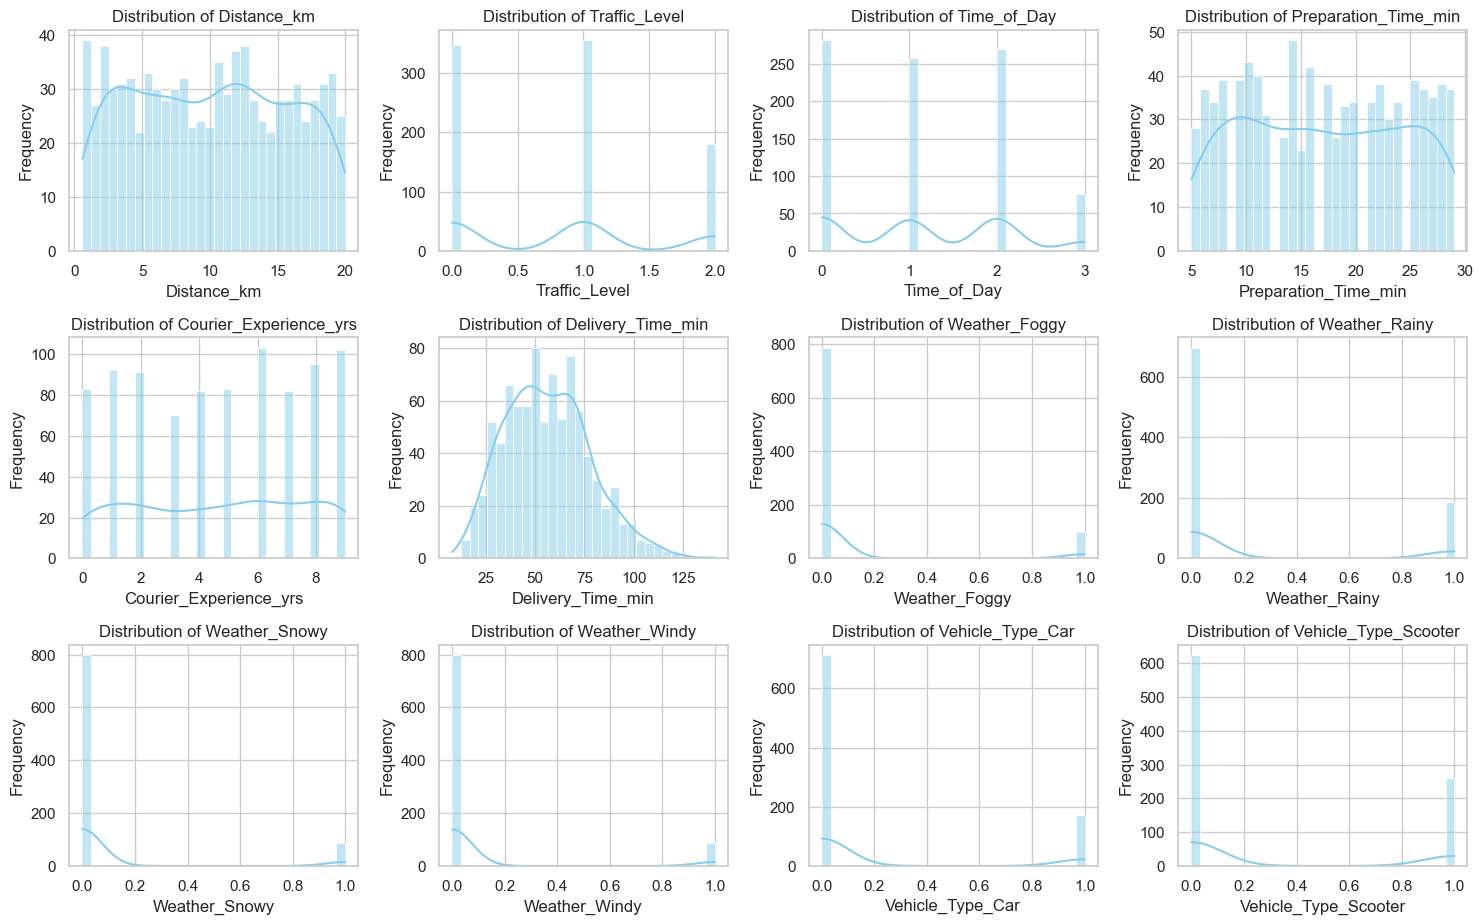

In [336]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color="skyblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any extra subplots
for j in range(len(df.columns), len(axes)):
    fig.delaxes(axes[j])
fig.savefig("distribution_plots.png", format="png")
plt.tight_layout()
plt.show()

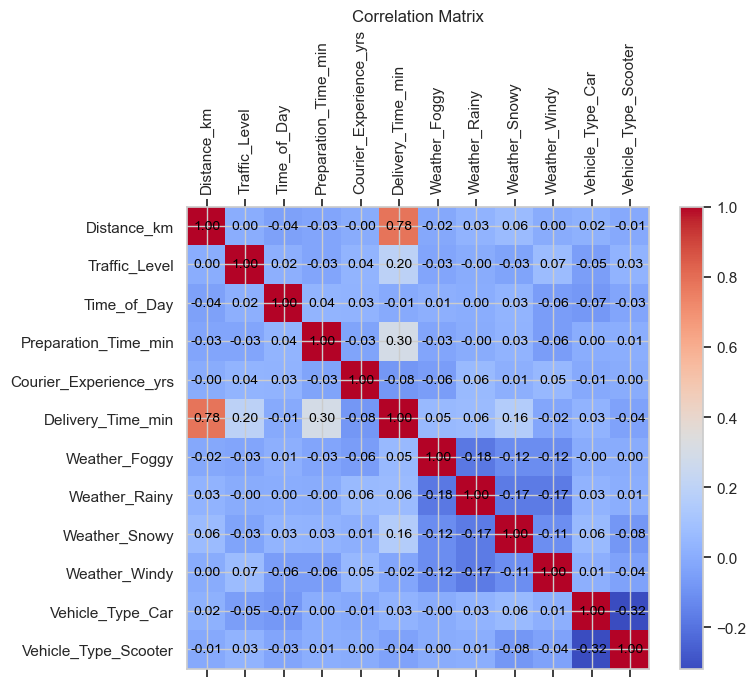

In [337]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

Seems like we reduced multicollinearity effect, which may make our model more accurate. 

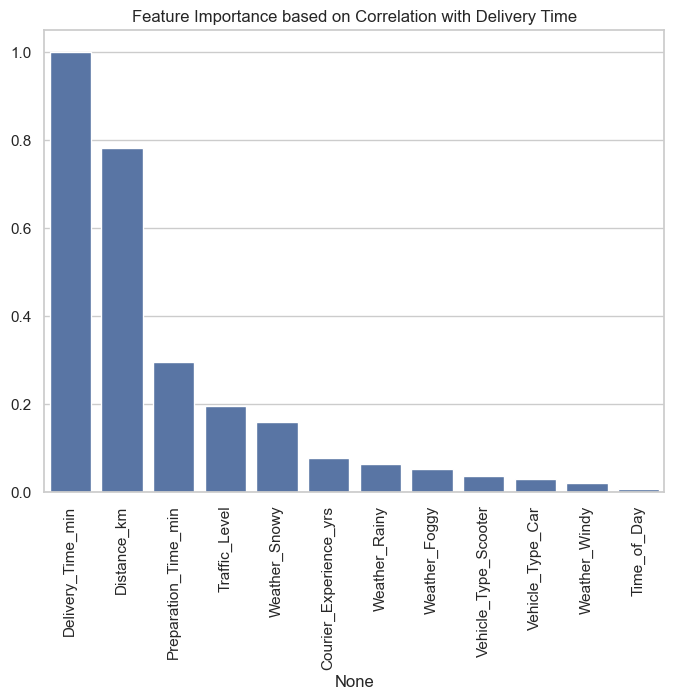

In [338]:
# Feature Importance using Correlation
plt.figure(figsize=(8,6))
sns.barplot(x=corr['Delivery_Time_min'].abs().sort_values(ascending=False).index,
            y=corr['Delivery_Time_min'].abs().sort_values(ascending=False).values)
plt.xticks(rotation=90)
plt.title('Feature Importance based on Correlation with Delivery Time')
plt.show()

However, this column now has the least impact on predicting the target variable, suggesting that this type of encoding may not improve the model's metrics.

In [339]:
# Example for Delivery Time
Q1 = df['Delivery_Time_min'].quantile(0.25)
Q3 = df['Delivery_Time_min'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Delivery_Time_min'] < lower_bound) | (df['Delivery_Time_min'] > upper_bound)]

In [340]:
df['Delivery_Time_min'] = df['Delivery_Time_min'].clip(lower=lower_bound, upper=upper_bound)
print(f"After capping/flooring, Delivery_Time_min range: Min = {df['Delivery_Time_min'].min()}, Max = {df['Delivery_Time_min'].max()}")

After capping/flooring, Delivery_Time_min range: Min = 8, Max = 116


In [341]:
outliers = df[(df['Delivery_Time_min'] < lower_bound) | (df['Delivery_Time_min'] > upper_bound)]
outliers

,Distance_km,Traffic_Level,Time_of_Day,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter


In [342]:
TARGET = 'Delivery_Time_min'
X = df.drop(TARGET, axis=1)
y = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

Train shape: (706, 11) | Test shape: (177, 11)


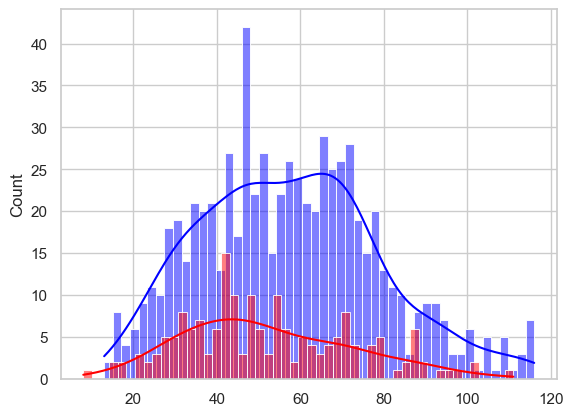

In [343]:
sns.histplot(y_train, kde=True, bins=50, color='blue')
sns.histplot(y_test, kde=True, bins=50, color='red')
plt.show()

In [344]:
X_train.head()

,Distance_km,Traffic_Level,Time_of_Day,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter
685,6.44,0,1,18,2.0,0,0,0,0,1,0
488,4.14,0,0,23,2.0,0,1,0,0,0,0
407,9.75,0,1,22,7.0,0,0,0,0,0,0
402,3.02,1,0,23,1.0,0,1,0,0,0,0
87,7.30,0,3,14,7.0,0,0,0,0,0,1


In [345]:
scale_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

# we apply scaling only to selected columns
scaler = StandardScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [261]:
X_train.head()

,Distance_km,Traffic_Level,Time_of_Day,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Vehicle_Type_Car,Vehicle_Type_Scooter
685,-0.669657,0,1,0.125871,-0.891439,0,0,0,0,1,0
488,-1.075507,0,0,0.812618,-0.891439,0,1,0,0,0,0
407,-0.085586,0,1,0.675269,0.814132,0,0,0,0,0,0
402,-1.273138,1,0,0.812618,-1.232553,0,1,0,0,0,0
87,-0.517905,0,3,-0.423526,0.814132,0,0,0,0,0,1


Training Linear Regression...
Linear Regression - MSE: 66.95, R²: 0.84
Training KNN Regressor...
KNN Regressor - MSE: 100.54, R²: 0.75
Training Decision Tree...
Decision Tree - MSE: 210.21, R²: 0.49
Training Random Forest...
Random Forest - MSE: 98.09, R²: 0.76
Training XGBoost...
XGBoost - MSE: 115.96, R²: 0.72
Training Support Vector Regressor...
Support Vector Regressor - MSE: 89.51, R²: 0.78
Training Gradient Boosting...
Gradient Boosting - MSE: 81.80, R²: 0.80

Model Evaluation Results:
                                 MSE        R²
Linear Regression          66.953264  0.836188
KNN Regressor             100.542825  0.754006
Decision Tree             210.214689  0.485676
Random Forest              98.085918  0.760017
XGBoost                   115.957042  0.716292
Support Vector Regressor   89.509141  0.781001
Gradient Boosting          81.798650  0.799866


C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\2293785936.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['R²'], palette="viridis")


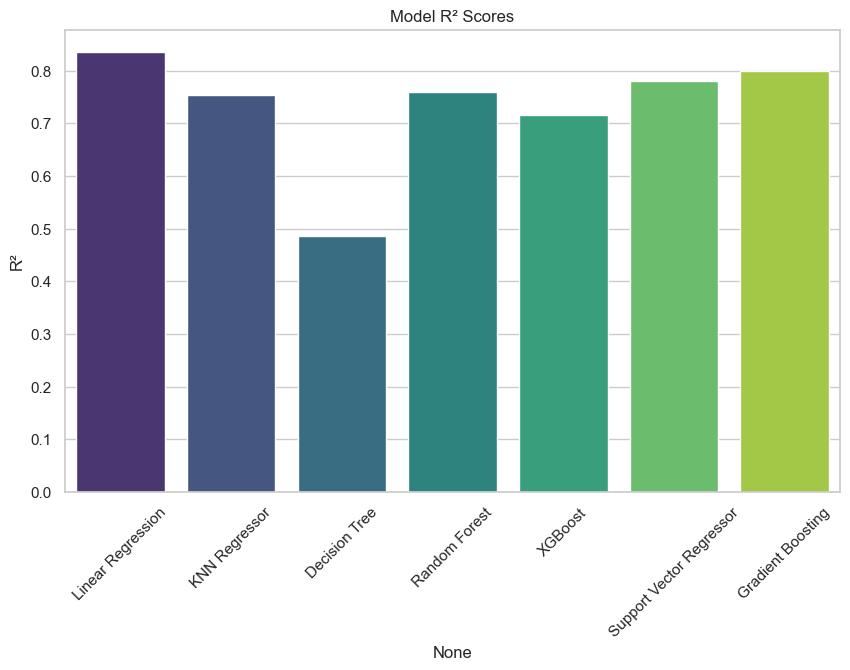

C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\2293785936.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['MSE'], palette="viridis")


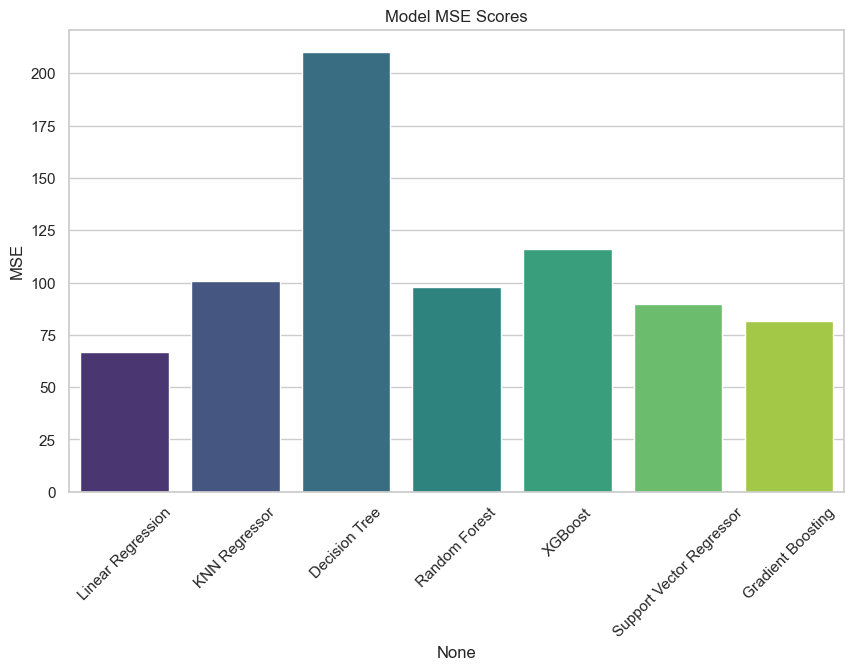

In [346]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# To store results
results = {}

# Iterate through models and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {'MSE': mse, 'R²': r2}

    print(f"{model_name} - MSE: {mse:.2f}, R²: {r2:.2f}")

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R²'], palette="viridis")
plt.title("Model R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['MSE'], palette="viridis")
plt.title("Model MSE Scores")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()

#### Better Models in First Results:
KNN Regressor, Decision Tree, Random Forest, XGBoost
#### Better Models in Second Results:
Linear Regression, Support Vector Regressor, Gradient Boosting

## GridSearchCV 

#### Note:
We performed the same processes twice: the first time with the original encoding method, and the second time as an experiment with a different encoding approach. After analyzing the results, we decided to retain the first encoding method due to its better performance.

To proceed with applying GridSearchCV for the models based on the first encoding method, re-run the cells from the beginning up to the data splitting step. We will perform the splitting now as a continuation of the first workflow.

Train shape: (564, 11) | Validation shape: (142, 11) | Test shape: (177, 11)
Tuning Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV MSE: 127.33
Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE: 134.84
Tuning Decision Tree...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV MSE: 171.98
Tuning XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV MSE: 122.99
Evaluating Gradient Boosting on the test set...
Gradient Boosting - Te

C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\2092940796.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_results_df.index, y=test_results_df['R²'], palette="viridis")


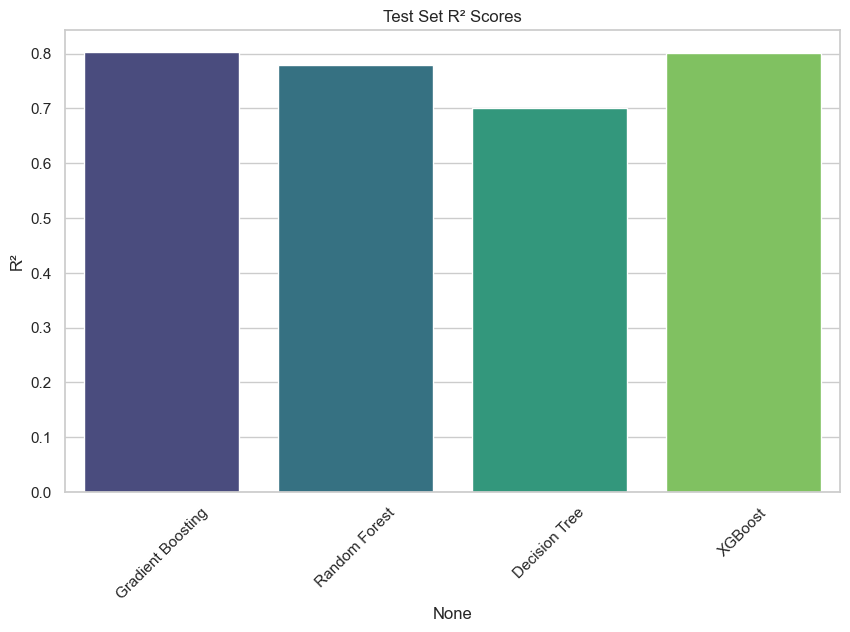

C:\Users\Acer\AppData\Local\Temp\ipykernel_10896\2092940796.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_results_df.index, y=test_results_df['MSE'], palette="viridis")


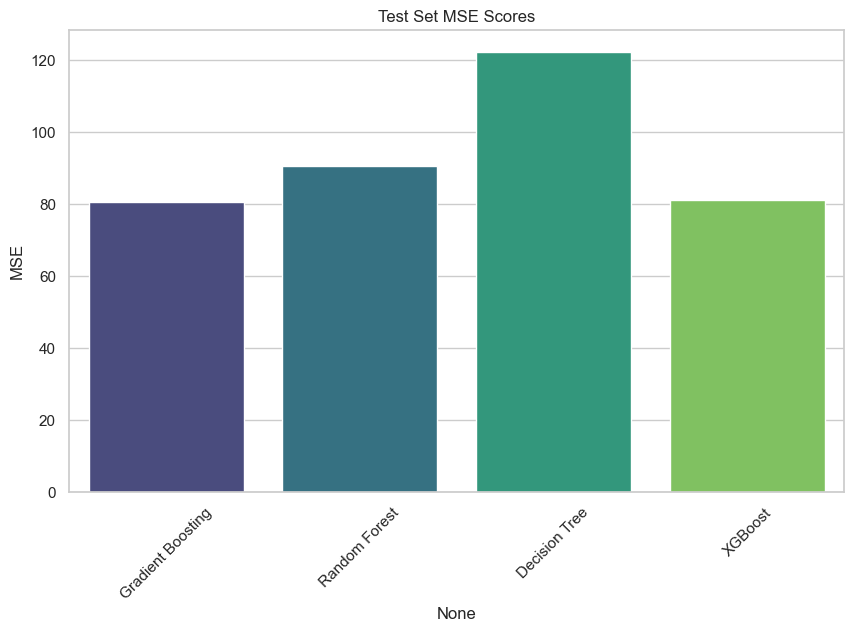

In [347]:
# Step 1: Split data into train+validation and test sets
TARGET = 'Delivery_Time_min'
X = df.drop(TARGET, axis=1)
y = df[TARGET].values

# Split into train+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+validation into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape} | Validation shape: {X_val.shape} | Test shape: {X_test.shape}")

# Step 2: Scale the numerical columns
scale_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
scaler = StandardScaler()

# Apply scaling to train, validation, and test sets
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

# Step 3: Define a function for GridSearchCV with k-fold CV
def perform_grid_search(model, param_grid, X_train, y_train):
    """
    Performs GridSearchCV with k-fold cross-validation.

    Args:
        model: Model to tune.
        param_grid: Hyperparameter grid.
        X_train: Training data.
        y_train: Training target values.

    Returns:
        Best model and grid search results.
    """
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold CV
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV MSE: {-grid_search.best_score_:.2f}")
    return grid_search.best_estimator_, grid_search

# Step 4: Perform GridSearchCV for selected models

# 1. Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}
print("Tuning Gradient Boosting...")
gb_best_model, gb_grid = perform_grid_search(GradientBoostingRegressor(random_state=42), gb_param_grid, X_train, y_train)

# 2. Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
print("Tuning Random Forest...")
rf_best_model, rf_grid = perform_grid_search(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train)

# 3. Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse'],
}
print("Tuning Decision Tree...")
dt_best_model, dt_grid = perform_grid_search(DecisionTreeRegressor(random_state=42), dt_param_grid, X_train, y_train)

# 4. XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
print("Tuning XGBoost...")
xgb_best_model, xgb_grid = perform_grid_search(XGBRegressor(random_state=42), xgb_param_grid, X_train, y_train)

# Step 5: Evaluate the best models on the test set
best_models = {
    'Gradient Boosting': gb_best_model,
    'Random Forest': rf_best_model,
    'Decision Tree': dt_best_model,
    'XGBoost': xgb_best_model
}

test_results = {}
for name, model in best_models.items():
    print(f"Evaluating {name} on the test set...")
    test_predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_results[name] = {'MSE': test_mse, 'R²': test_r2}
    print(f"{name} - Test MSE: {test_mse:.2f}, R²: {test_r2:.2f}")

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("\nTest Set Evaluation Results:")
print(test_results_df)

# Plot the test results
plt.figure(figsize=(10, 6))
sns.barplot(x=test_results_df.index, y=test_results_df['R²'], palette="viridis")
plt.title("Test Set R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=test_results_df.index, y=test_results_df['MSE'], palette="viridis")
plt.title("Test Set MSE Scores")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()


### Summary:
After applying GridSearchCV, Gradient Boosting, Random Forest, XGBoost, and Decision Tree all showed performance improvements. Gradient Boosting improved slightly (MSE: 82.00 → 78.86, R²: 0.80 → 0.81), while XGBoost saw moderate gains (MSE: 110.45 → 79.90, R²: 0.73 → 0.80). Decision Tree had the most significant improvement (MSE: 187.63 → 122.20, R²: 0.54 → 0.70), but it still underperforms compared to other models. Despite these enhancements, Linear Regression remains the best-performing model with MSE: 67.12 and R²: 0.84, indicating that a simple approach may be sufficient for this dataset.

### Limitations
- **Feature Engineering:** We used basic transformations and one-hot encoding but did not explore advanced techniques like interaction terms or polynomial features.
- **Outliers & Noise:** While we applied capping for outliers, alternative treatments could be explored.
- **Model Selection:** More complex models like **Neural Networks or CatBoost** were not tested, which might yield better results.